# 라이브러리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns

In [3]:
import matplotlib.font_manager as fm
!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


# 데이터

In [4]:
data = pd.read_csv('/content/drive/Shareddrives/서울시 빅데이터(2022-2)/논문/3. 폐업 여부 분류 모델/0) 데이터/data_PredIndex.csv')

In [5]:
data['폐업여부']=data['폐업여부'].apply(lambda x: 1 if x=="Y" else 0)
data['프랜차이즈여부']=data['프랜차이즈여부'].apply(lambda x: 1 if x=="Y" else 0)

In [6]:
data['표준산업분류코드']=data['표준산업분류코드'].astype('category')
data['행정동코드']=data['행정동코드'].astype('category')
data['분기']=data['분기'].astype('category')

In [10]:
train_data = data[data['년도'] == 2021]
test_data = data[data['년도'] == 2022]

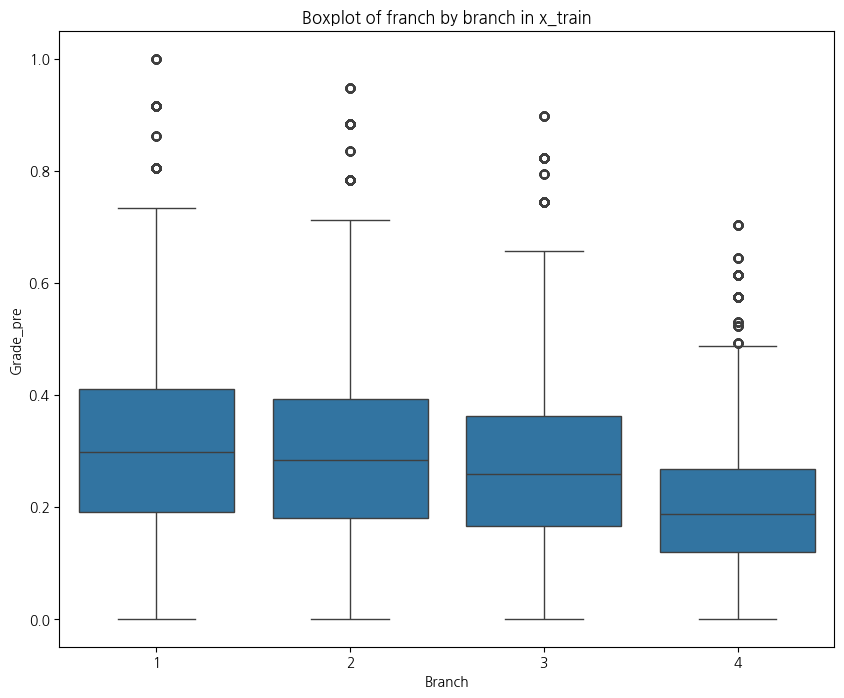

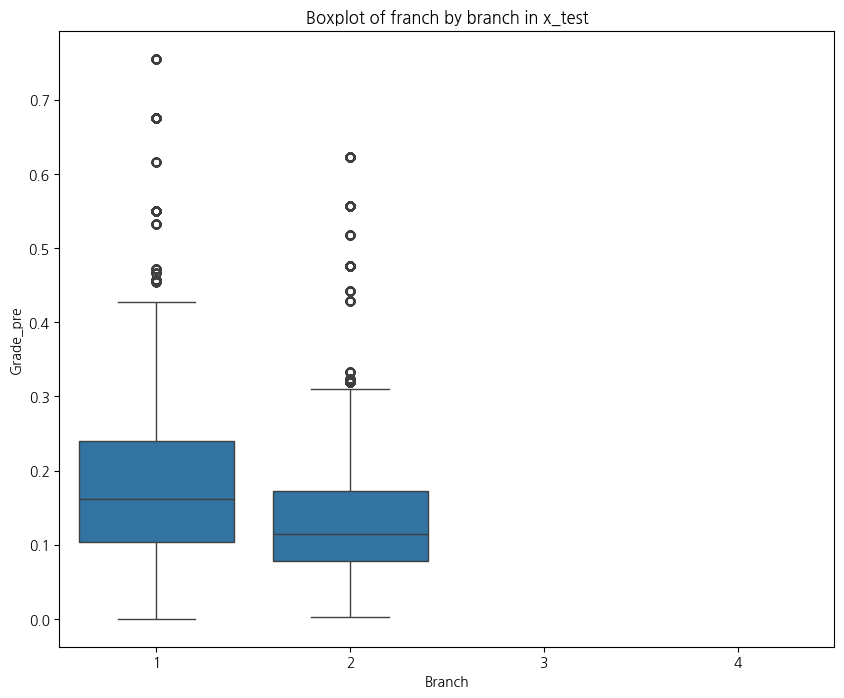

In [11]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='분기', y='franch_pre', data=train_data)
plt.title('Boxplot of franch by branch in x_train')
plt.xlabel('Branch')
plt.ylabel('Grade_pre')
plt.show()

plt.figure(figsize=(10, 8))
sns.boxplot(x='분기', y='franch_pre', data=test_data)
plt.title('Boxplot of franch by branch in x_test')
plt.xlabel('Branch')
plt.ylabel('Grade_pre')
plt.show()

In [12]:
data_encoded = pd.get_dummies(data, columns=['표준산업분류코드', '행정동코드', '분기'])
data_encoded = data_encoded.drop(['점포명'], axis=1)

In [13]:
train_data = data_encoded[data_encoded['년도'] == 2021]
test_data = data_encoded[data_encoded['년도'] == 2022]

In [14]:
train_data = train_data.drop(['년도'], axis=1)
test_data = test_data.drop(['년도'], axis=1)

In [15]:
x_train = train_data.drop(['폐업여부'], axis=1)
y_train = train_data['폐업여부']
x_test = test_data.drop(['폐업여부'], axis=1)
y_test = test_data['폐업여부']

# 모델링

In [16]:
model = XGBClassifier(random_state=42,learning_rate=0.1, max_depth=8, n_estimators=100)
model.fit(x_train, y_train)

ens_score = model.predict_proba(x_test)[:, 1]
roc_score = roc_auc_score(y_test, ens_score)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

precision, recall, _ = precision_recall_curve(y_test, ens_score)
pr_auc_score = auc(recall, precision)
print("PR AUC:", pr_auc_score)

ROC AUC 값: 0.5858
PR AUC: 0.0501786789909575


# 결과 확인

In [17]:
ens_score = model.predict_proba(x_train)[:, 1]
threshold = np.percentile(ens_score, 95)

ens_score_test = model.predict_proba(x_test)[:, 1]

test_pred = (ens_score_test > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, test_pred)
print("Confusion Matrix:")
print(conf_matrix)

tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Threshold:", threshold)
print("특이도 (Specificity):", specificity)
print("민감도 (Sensitivity):", sensitivity)

Confusion Matrix:
[[21309   990]
 [  821    60]]
Threshold: 0.07359294518828388
특이도 (Specificity): 0.9556033902865599
민감도 (Sensitivity): 0.0681044267877412


In [18]:
def find_threshold(model, X, y_true, target_specificity=0.95):

    y_prob = model.predict_proba(X)[:, 1]

    thresholds = np.linspace(0, 1, 100)
    sensitivities = []
    specificities = []

    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)

        specificities.append(specificity)
        sensitivities.append(sensitivity)

        if specificity >= target_specificity:
            break

    optimal_threshold = thresholds[len(specificities) - 1]
    optimal_sensitivity = sensitivities[len(specificities) - 1]

    return optimal_threshold, optimal_sensitivity

optimal_threshold, optimal_sensitivity = find_threshold(model, x_train, y_train)
print(f'Optimal Threshold: {optimal_threshold}, Sensitivity at 95% Specificity: {optimal_sensitivity}')

ens_score_test = model.predict_proba(x_test)[:, 1]
test_pred = (ens_score_test > optimal_threshold).astype(int)

conf_matrix = confusion_matrix(y_test, test_pred)
print("Confusion Matrix:")
print(conf_matrix)

tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Threshold:", optimal_threshold)
print("특이도 (Specificity):", specificity)
print("민감도 (Sensitivity):", sensitivity)

Optimal Threshold: 0.07070707070707072, Sensitivity at 95% Specificity: 0.3600451467268623
Confusion Matrix:
[[21149  1150]
 [  809    72]]
Threshold: 0.07070707070707072
특이도 (Specificity): 0.948428180635903
민감도 (Sensitivity): 0.08172531214528944


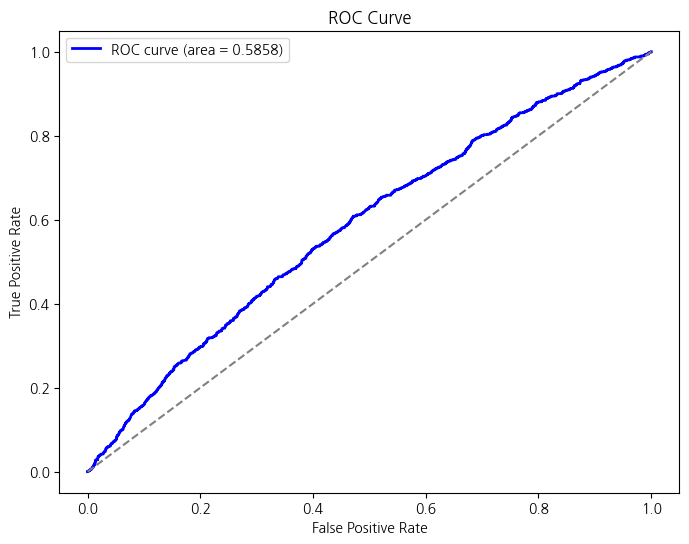

In [19]:
y_prob = model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.4f})'.format(roc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [20]:
feature_order = model.get_booster().feature_names
data_encoded_reordered = data_encoded[feature_order]
predicted_probabilities = model.predict_proba(data_encoded_reordered)[:, 1]
data_encoded['Predicted_Probability'] = predicted_probabilities

sic_columns = data_encoded.columns[data_encoded.columns.str.startswith('표준산업분류코드_')]
mean_prob_by_sic = data_encoded[sic_columns].mean()
lowest_prob_sic_code = mean_prob_by_sic.idxmin()
lowest_prob_sic_prob = mean_prob_by_sic.min()

dong_columns = data_encoded.columns[data_encoded.columns.str.startswith('행정동코드_')]
mean_prob_by_dong = data_encoded[dong_columns].mean()
lowest_prob_dong_code = mean_prob_by_dong.idxmin()
lowest_prob_dong_prob = mean_prob_by_dong.min()

print('가장 낮은 폐업 확률을 가진 SIC 코드:', lowest_prob_sic_code)
print('폐업 확률:', lowest_prob_sic_prob)
print('가장 낮은 폐업 확률을 가진 행정동 코드:', lowest_prob_dong_code)
print('폐업 확률:', lowest_prob_dong_prob)

가장 낮은 폐업 확률을 가진 SIC 코드: 표준산업분류코드_85509
폐업 확률: 1.3839872673171406e-05
가장 낮은 폐업 확률을 가진 행정동 코드: 행정동코드_11680660
폐업 확률: 2.7679745346342812e-05


In [21]:
test1 = data_encoded[data_encoded['표준산업분류코드_56191'] == 1]
test1 = test1.drop_duplicates()

ens_score = model.predict_proba(test1[feature_order])[:, 1]

ens_score_df = pd.DataFrame({'pred': ens_score})
test1_a = pd.concat([test1.reset_index(), ens_score_df], axis=1)
test1_a = test1_a.sort_values('pred')
test1_a

,index,년도,프랜차이즈여부,폐업여부,grade_pre,result_pre,sales_pre,infra_pre,franch_pre,pop_pre,...,행정동코드_11740660,행정동코드_11740685,행정동코드_11740690,행정동코드_11740700,분기_1,분기_2,분기_3,분기_4,Predicted_Probability,pred
629,42480,2021,1,0,0.232538,0.111111,0.196946,0.208449,0.068308,0.472635,...,False,False,False,False,False,False,False,True,0.003970,0.003970
653,44704,2021,0,0,0.380640,0.555556,0.226798,0.070660,0.011575,0.111187,...,False,False,False,False,False,False,False,True,0.004042,0.004042
524,36979,2021,0,0,0.545693,0.888889,0.432333,0.266967,0.121846,0.308867,...,False,False,False,False,False,False,False,True,0.004672,0.004672
478,32819,2021,1,0,0.124854,0.000000,0.122170,0.121884,0.065846,0.361476,...,False,False,False,False,False,False,True,False,0.004676,0.004676
521,36740,2021,1,0,0.489244,0.888889,0.419707,0.270429,0.119385,0.263474,...,False,False,False,False,False,False,False,True,0.004746,0.004746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,12529,2021,1,1,0.259313,0.111111,0.147446,0.194945,0.206154,0.509546,...,False,False,False,False,False,True,False,False,0.096578,0.096578
594,40328,2021,0,0,0.150757,0.000000,0.101632,0.163781,0.066462,0.463725,...,False,False,False,False,False,False,False,True,0.098539,0.098539
411,28809,2021,1,1,0.352154,0.444444,0.135334,0.218144,0.271385,0.619431,...,False,False,False,False,False,False,True,False,0.119886,0.119886
516,36248,2021,1,0,0.352154,0.444444,0.135334,0.218144,0.271385,0.619431,...,False,False,False,False,False,False,True,False,0.119886,0.119886


In [22]:
top_3_lowest_pred = test1_a.head(3)

matching_columns = top_3_lowest_pred.iloc[:, :-1].columns[top_3_lowest_pred.iloc[:, :-1].columns.str.startswith('행정동코드_') & (top_3_lowest_pred.iloc[:, :-1] == 1).any()]
print(matching_columns)

Index(['행정동코드_11110550', '행정동코드_11170625', '행정동코드_11470640'], dtype='object')


In [24]:
bottom_3_highest_pred = test1_a.tail(4)

matching_columns = bottom_3_highest_pred.iloc[:, :-1].columns[bottom_3_highest_pred.iloc[:, :-1].columns.str.startswith('행정동코드_') & (bottom_3_highest_pred.iloc[:, :-1] == 1).any()]
print(matching_columns)

Index(['행정동코드_11530770', '행정동코드_11680730', '행정동코드_11740520'], dtype='object')


In [25]:
test2 = data_encoded[data_encoded['행정동코드_11710566'] == 1]
test2 = test2.drop_duplicates()

ens_score2 = model.predict_proba(test2[feature_order])[:, 1]

ens_score_df2 = pd.DataFrame({'pred': ens_score2})
test2_a = pd.concat([test2.reset_index(), ens_score_df2], axis=1)
test2_a = test2_a.sort_values('pred')
test2_a

,index,년도,프랜차이즈여부,폐업여부,grade_pre,result_pre,sales_pre,infra_pre,franch_pre,pop_pre,...,행정동코드_11740660,행정동코드_11740685,행정동코드_11740690,행정동코드_11740700,분기_1,분기_2,분기_3,분기_4,Predicted_Probability,pred
23,48633,2021,0,0,0.411932,0.664167,0.957718,0.057803,0.009852,0.120102,...,False,False,False,False,False,False,False,True,0.005690,0.005690
25,52074,2022,0,0,0.406344,0.652222,0.940088,0.057743,0.011754,0.145831,...,False,False,False,False,True,False,False,False,0.007523,0.007523
0,3038,2021,0,0,0.400815,0.556667,0.923117,0.055456,0.014769,0.133632,...,False,False,False,False,True,False,False,False,0.007523,0.007523
27,55110,2022,1,0,0.406048,0.651944,0.940067,0.057742,0.011772,0.145824,...,False,False,False,False,True,False,False,False,0.007540,0.007540
36,67244,2022,1,0,0.403161,0.642222,0.941157,0.054453,0.011145,0.113342,...,False,False,False,False,False,True,False,False,0.008865,0.008865
16,28880,2021,0,0,0.407327,0.666667,0.938176,0.057819,0.011674,0.122164,...,False,False,False,False,False,False,True,False,0.011651,0.011651
12,24605,2021,0,0,0.407159,0.666111,0.938968,0.057481,0.014769,0.132798,...,False,False,False,False,False,True,False,False,0.013569,0.013569
28,59203,2022,0,0,0.407180,0.656389,0.940179,0.057739,0.011822,0.145840,...,False,False,False,False,True,False,False,False,0.013637,0.013637
34,67242,2022,0,0,0.403302,0.642500,0.941157,0.054459,0.011200,0.113365,...,False,False,False,False,False,True,False,False,0.014870,0.014870
13,24606,2021,0,0,0.407159,0.666667,0.938915,0.057480,0.014769,0.132798,...,False,False,False,False,False,True,False,False,0.014870,0.014870


In [26]:
top_3_lowest_pred = test2_a.head(4)

matching_columns = top_3_lowest_pred.iloc[:, :-1].columns[top_3_lowest_pred.iloc[:, :-1].columns.str.startswith('표준산업분류코드_') & (top_3_lowest_pred.iloc[:, :-1] == 1).any()]
print(matching_columns)

Index(['표준산업분류코드_47599', '표준산업분류코드_47811', '표준산업분류코드_96912'], dtype='object')


In [27]:
bottom_3_highest_pred = test2_a.tail(4)

matching_columns = bottom_3_highest_pred.iloc[:, :-1].columns[bottom_3_highest_pred.iloc[:, :-1].columns.str.startswith('표준산업분류코드_') & (bottom_3_highest_pred.iloc[:, :-1] == 1).any()]
print(matching_columns)

Index(['표준산업분류코드_47122', '표준산업분류코드_47219', '표준산업분류코드_56111'], dtype='object')


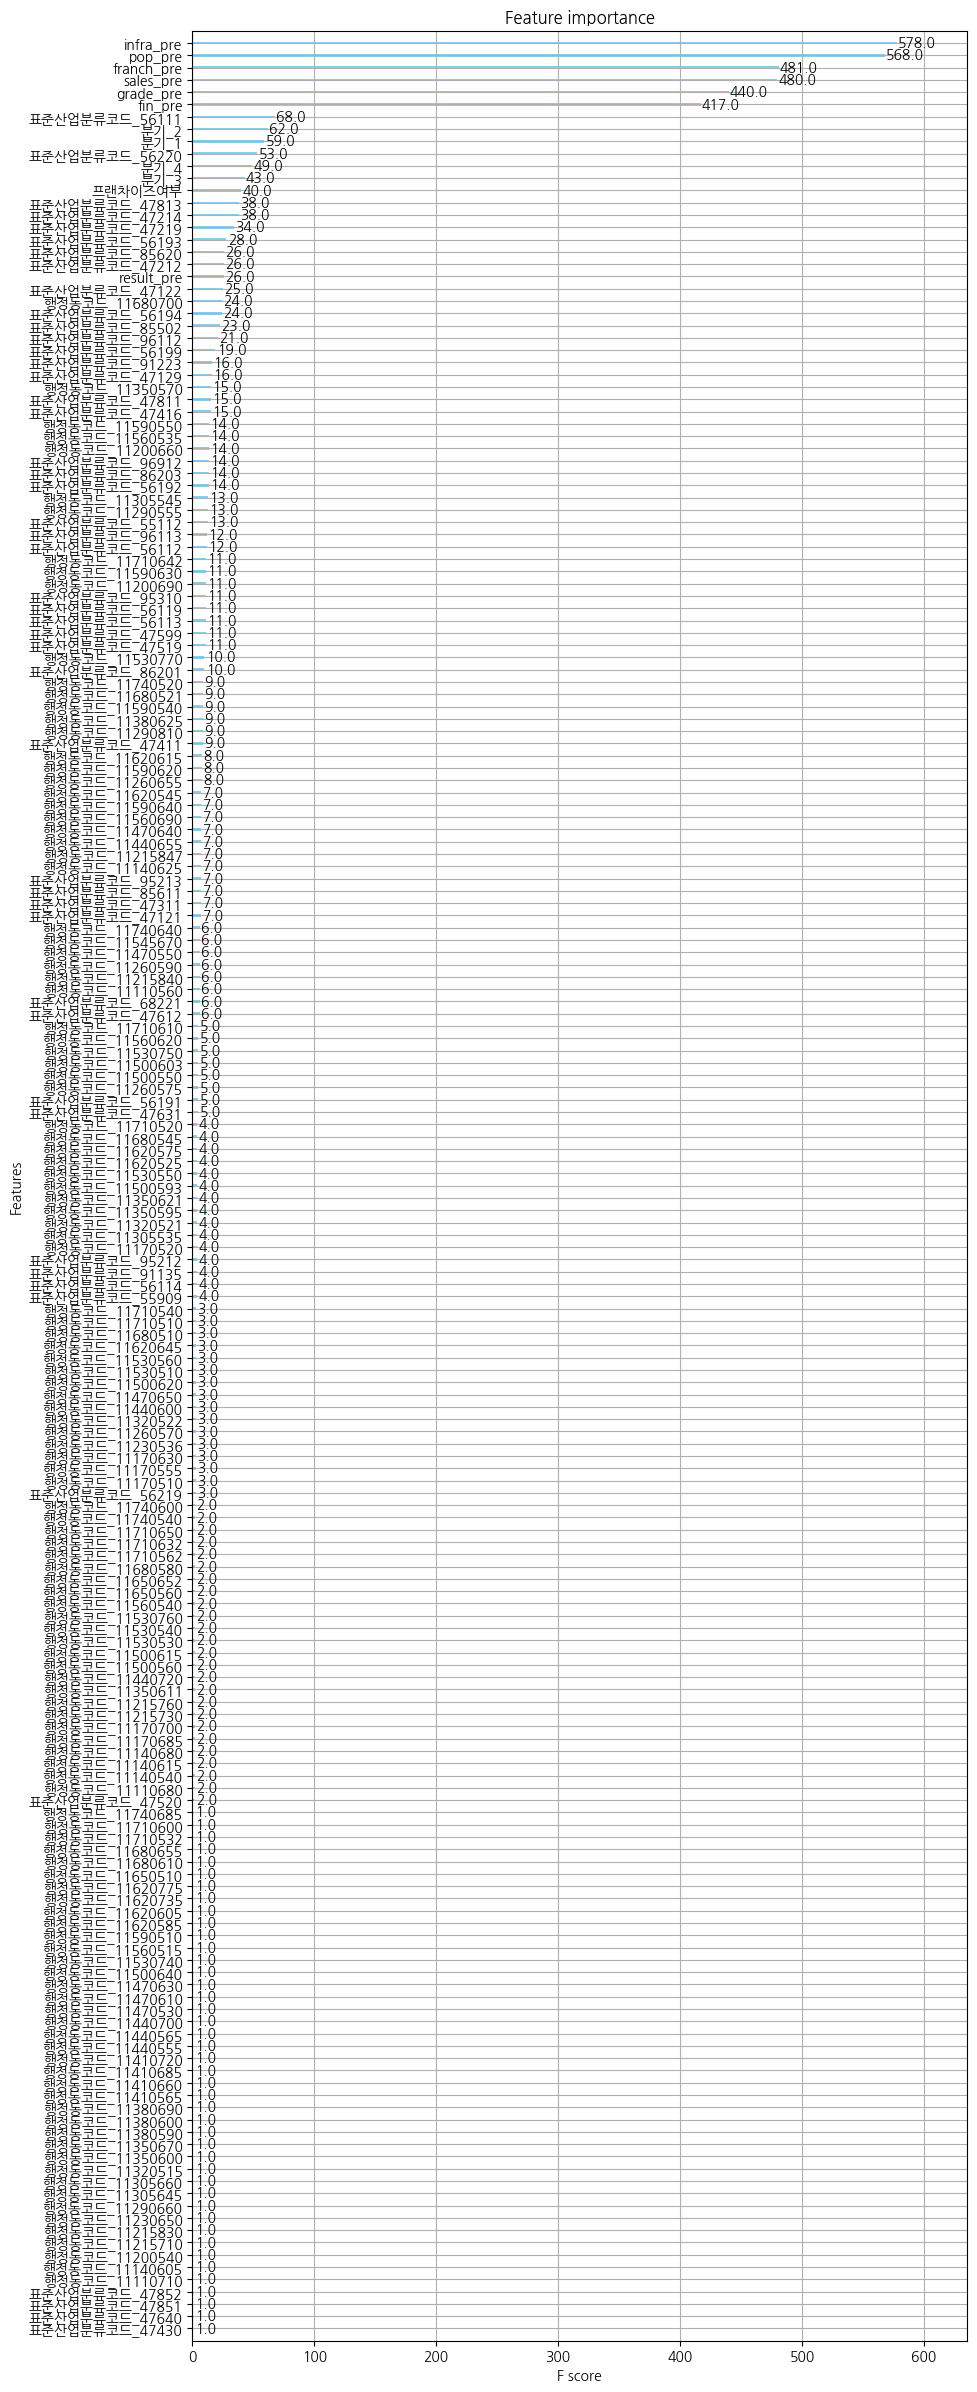

In [28]:
feature_names = x_train.columns
fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(model, ax=ax, color='skyblue')
plt.show()